# Summary
- Analysis of fine-tuned models

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [2]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results5_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [4]:
network_l

['xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_4',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_6',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_7',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11',
 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12',
 'xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0',
 'xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1',
 'xlnet_base_cased-ptb_pos_dev_qnli_i

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [5]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [6]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [7]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [8]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0
            maxcorr  minlinreg   mincorr  maxlinreg
maxcorr    1.000000   0.127746  0.052248   0.646360
minlinreg  0.127746   1.000000  0.607750   0.173463
mincorr    0.052248   0.607750  1.000000   0.101822
maxlinreg  0.646360   0.173463  0.101822   1.000000
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1
            maxcorr  minlinreg   mincorr  maxlinreg
maxcorr    1.000000  -0.295072 -0.172305   0.902854
minlinreg -0.295072   1.000000  0.570897  -0.336561
mincorr   -0.172305   0.570897  1.000000  -0.183025
maxlinreg  0.902854  -0.336561 -0.183025   1.000000
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2
            maxcorr  minlinreg   mincorr  maxlinreg
maxcorr    1.000000  -0.344825 -0.182513   0.925523
minlinreg -0.344825   1.000000  0.540138  -0.298883
mincorr   -0.182513   0.540138  1.000000  -0.160275
maxlinreg  0.925523  -0.298883 -0.160275   1.000000
xlnet_base_cased-ptb_pos_dev_mnli_includ

### Distributions

In [9]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    504
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0     144
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      112
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         8
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      168
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     126
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      124
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      110
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        92
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     72
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      36
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10      14
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     

          max       min       med
max  1.000000 -0.298883  0.883421
min -0.298883  1.000000 -0.117017
med  0.883421 -0.117017  1.000000


xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2      730
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_4       36
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3      1
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3        1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    159
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      114
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      110
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     100
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        98
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       92
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      4

          max       min       med
max  1.000000  0.280600  0.826738
min  0.280600  1.000000  0.367898
med  0.826738  0.367898  1.000000


xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_6:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5      707
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_7       60
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    139
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       128
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      119
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     108
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11       94
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       89
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8        40
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12      3


maxcounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9    768
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0       254
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      207
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8       128
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      118
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      47
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      8
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9         6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.269678 -0.227308
min -0.269678  1.000000  0.871401
med -0.227308  0.871401  1.000000


xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10    493
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11    217
xlnet_base_cased-ptb_pos_dev_mnli

          max       min       med
max  1.000000  0.208798  0.306108
min  0.208798  1.000000  0.913821
med  0.306108  0.913821  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10    591
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12    119
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      58
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      263
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0     138
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    117
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        88
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       82
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8        15
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7        13
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9         9
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12     

          max       min       med
max  1.000000 -0.398891  0.753564
min -0.398891  1.000000 -0.112132
med  0.753564 -0.112132  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_1    534
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1     233
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      176
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     128
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      116
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      112
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        93
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     57
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      34
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      23
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8   

          max       min       med
max  1.000000 -0.383505  0.970716
min -0.383505  1.000000 -0.338507
med  0.970716 -0.338507  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    365
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3      319
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_5       78
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4       5
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     152
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    137
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      102
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       101
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       93
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11       90
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11 

          max       min       med
max  1.000000  0.058607  0.910168
min  0.058607  1.000000  0.146209
med  0.910168  0.146209  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_8      538
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_6      229
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    173
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     152
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       122
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       83
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       79
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11       74
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8        31
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      29
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10 

          max       min       med
max  1.000000  0.096279  0.213512
min  0.096279  1.000000  0.650276
med  0.213512  0.650276  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_9     407
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11    358
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      3
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    247
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     149
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       59
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0       44
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      39
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        33
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       23
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1       23
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11     

          max       min       med
max  1.000000 -0.514852  0.492752
min -0.514852  1.000000  0.191643
med  0.492752  0.191643  1.000000


xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11    766
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_10      2
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      466
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0     155
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        70
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       20
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1       12
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1       8
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_1         6
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_1      5
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      5

          max       min       med
max  1.000000 -0.333562  0.756838
min -0.333562  1.000000 -0.035587
med  0.756838 -0.035587  1.000000


xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_2    548
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_2     108
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2       99
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_1         8
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3         4
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     177
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      127
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       95
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11       95
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        93

          max       min       med
max  1.000000 -0.376989  0.920016
min -0.376989  1.000000 -0.380963
med  0.920016 -0.380963  1.000000


xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_5:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_4     653
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_6      88
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10     19
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      5
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3       3
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     553
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12      120
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12       44
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11       19
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10        8
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0         7
xln

          max       min       med
max  1.000000  0.476916  0.608401
min  0.476916  1.000000  0.847679
med  0.608401  0.847679  1.000000


xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11    232
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9     186
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12    172
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10    171
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7       7
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      405
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      194
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      58
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        51
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1       19
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_2     17
xlnet_bas

          max       min       med
max  1.000000  0.419414  0.443063
min  0.419414  1.000000  0.939853
med  0.443063  0.939853  1.000000


xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12    356
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10    207
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8     119
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9      84
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7       2
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      386
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      243
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      49
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        41
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1       24
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_2     14
xlnet_ba

          max       min       med
max  1.000000  0.184456  0.602564
min  0.184456  1.000000  0.305284
med  0.602564  0.305284  1.000000


xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_1    758
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1        9
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      165
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      128
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     125
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      116
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       107
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     49
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      27
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      

          max       min       med
max  1.000000 -0.427470  0.961415
min -0.427470  1.000000 -0.395395
med  0.961415 -0.395395  1.000000


xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    744
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3      14
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_5       9
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      163
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      129
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     125
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      123
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        99
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      35
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      

          max       min       med
max  1.000000  0.034429  0.923029
min  0.034429  1.000000  0.083949
med  0.923029  0.083949  1.000000


xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_7:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_6     435
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_8     332
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       166
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     164
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      138
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      106
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       97
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      31
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      24
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8        

          max       min       med
max  1.000000  0.477067  0.266356
min  0.477067  1.000000  0.666741
med  0.266356  0.666741  1.000000


xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10:

maxcorr

maxcounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    355
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     283
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    128
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_8       2
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      112
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     110
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0       95
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        92
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       57
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        50
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      

          max       min       med
max  1.000000  0.018553  0.406700
min  0.018553  1.000000  0.768854
med  0.406700  0.768854  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    593
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    173
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9       2
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      198
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0       104
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        59
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       55
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      46
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12      44
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       44
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0     35
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7   

          max       min       med
max  1.000000 -0.423502  0.709211
min -0.423502  1.000000 -0.103262
med  0.709211 -0.103262  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1     757
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1       10
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      172
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      128
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     123
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      102
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9        93
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     57
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      39
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      24
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8   

          max       min       med
max  1.000000 -0.480191  0.958805
min -0.480191  1.000000 -0.432221
med  0.958805 -0.432221  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4     440
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_5    182
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    142
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_4        3
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     132
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       130
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      128
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      104
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      102
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     88
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11 

          max       min       med
max  1.000000 -0.251465  0.934008
min -0.251465  1.000000 -0.254412
med  0.934008 -0.254412  1.000000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_6    530
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_8    238
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     137
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      124
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      123
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       123
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10       87
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     72
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      41
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8        28
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      17
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10 

          max       min      med
max  1.000000  0.066419  0.88213
min  0.066419  1.000000 -0.02028
med  0.882130 -0.020280  1.00000

mincorr

maxcounts
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_9     608
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_11    159
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0       1
dtype: int64

mincounts
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       139
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      137
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     132
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      102
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11       97
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     64
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8        29
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10      24
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11  

# LinCKA

In [10]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [11]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [12]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [13]:
# rbfcka_df

In [14]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [15]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [16]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [17]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [18]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [19]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [20]:
short_labels = [label.split('_')[0] + ' ' + label.split('_')[-4] + ' ' + label.split('_')[-1] for label in network_l]
print(short_labels)

['xlnet mnli 0', 'xlnet mnli 1', 'xlnet mnli 2', 'xlnet mnli 3', 'xlnet mnli 4', 'xlnet mnli 5', 'xlnet mnli 6', 'xlnet mnli 7', 'xlnet mnli 8', 'xlnet mnli 9', 'xlnet mnli 10', 'xlnet mnli 11', 'xlnet mnli 12', 'xlnet qnli 0', 'xlnet qnli 1', 'xlnet qnli 2', 'xlnet qnli 3', 'xlnet qnli 4', 'xlnet qnli 5', 'xlnet qnli 6', 'xlnet qnli 7', 'xlnet qnli 8', 'xlnet qnli 9', 'xlnet qnli 10', 'xlnet qnli 11', 'xlnet qnli 12', 'xlnet qqp 0', 'xlnet qqp 1', 'xlnet qqp 2', 'xlnet qqp 3', 'xlnet qqp 4', 'xlnet qqp 5', 'xlnet qqp 6', 'xlnet qqp 7', 'xlnet qqp 8', 'xlnet qqp 9', 'xlnet qqp 10', 'xlnet qqp 11', 'xlnet qqp 12', 'xlnet sst-2 0', 'xlnet sst-2 1', 'xlnet sst-2 2', 'xlnet sst-2 3', 'xlnet sst-2 4', 'xlnet sst-2 5', 'xlnet sst-2 6', 'xlnet sst-2 7', 'xlnet sst-2 8', 'xlnet sst-2 9', 'xlnet sst-2 10', 'xlnet sst-2 11', 'xlnet sst-2 12', 'xlnet unfine 0', 'xlnet unfine 1', 'xlnet unfine 2', 'xlnet unfine 3', 'xlnet unfine 4', 'xlnet unfine 5', 'xlnet unfine 6', 'xlnet unfine 7', 'xlnet unfi

In [21]:
plt.rcParams["figure.figsize"] = (20,15)

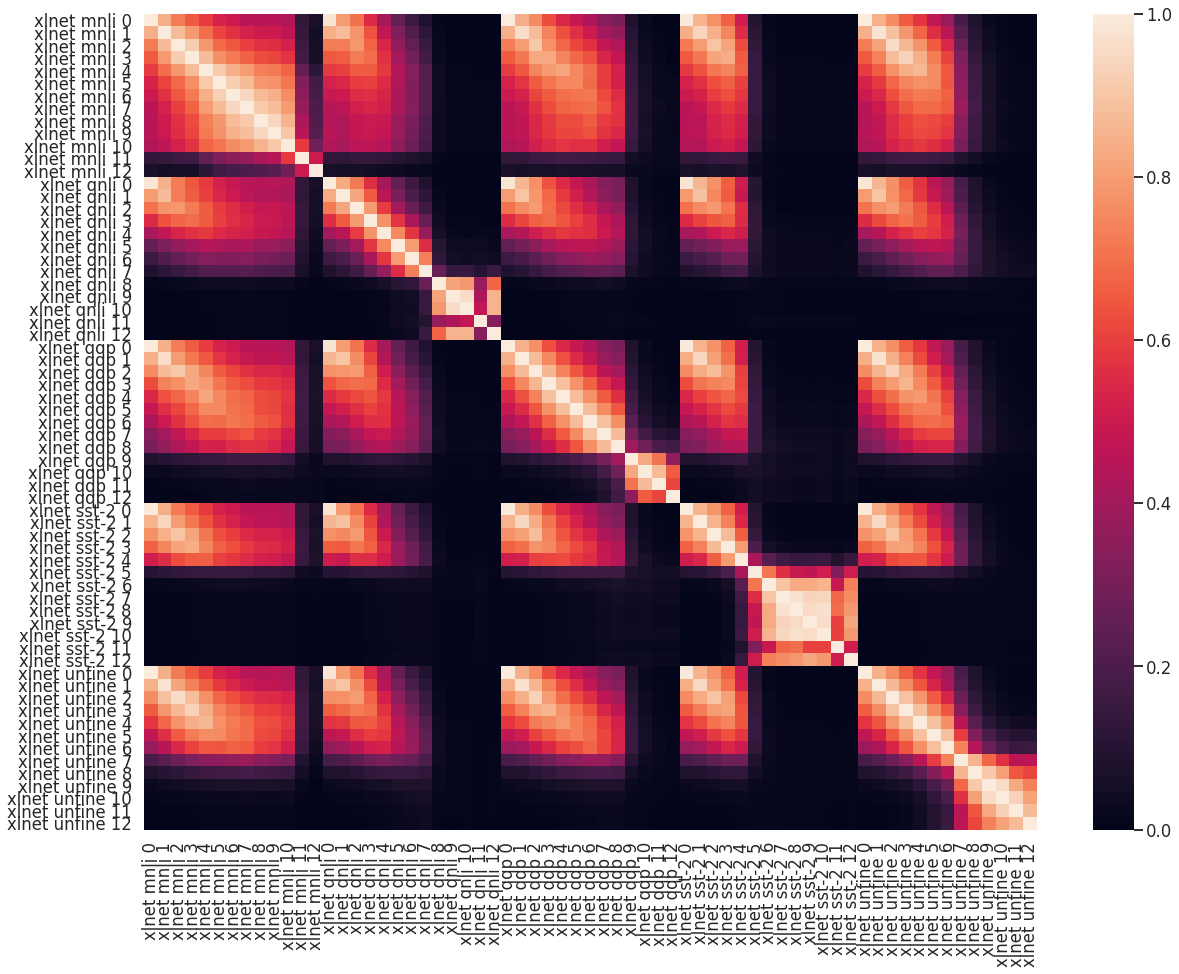

In [22]:
# lincka
g = sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1, xticklabels=short_labels, yticklabels=short_labels)
g.get_figure().savefig('xlnet-lincka-heatmap-finetuned.pdf')

In [23]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


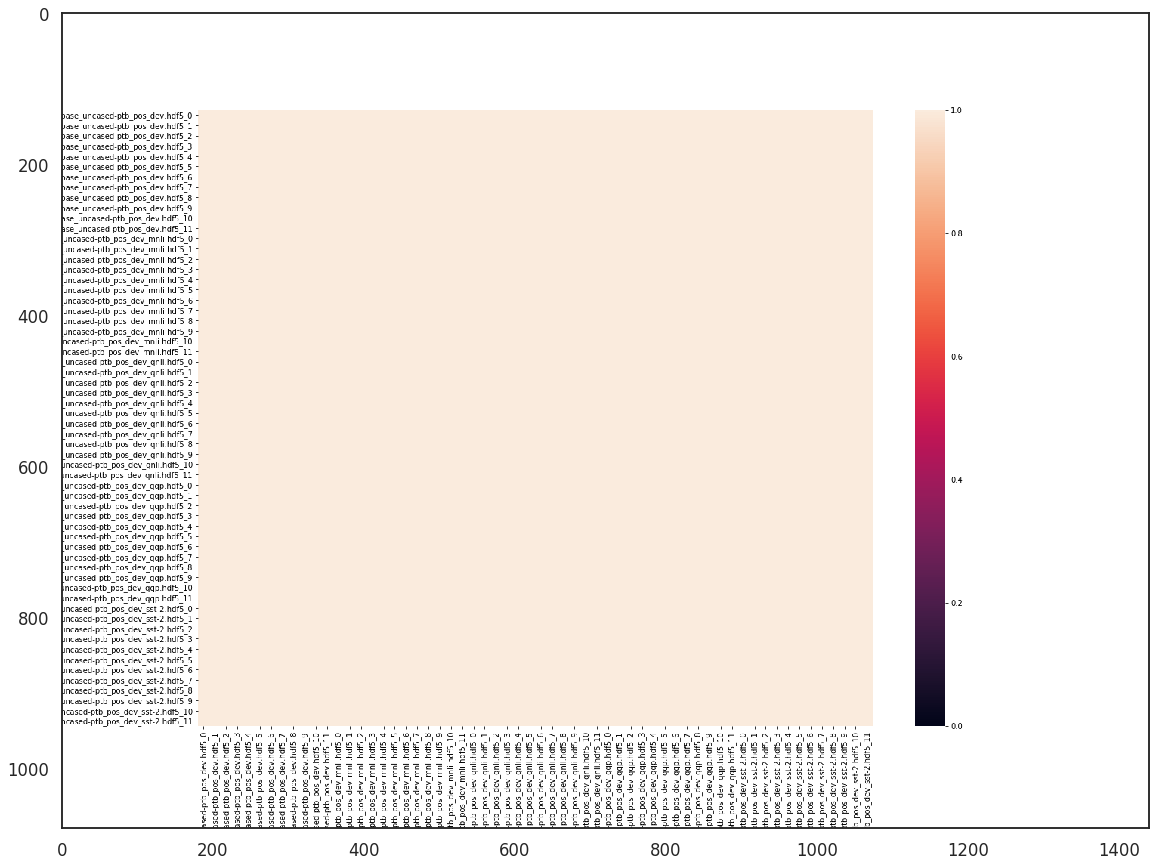

In [24]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


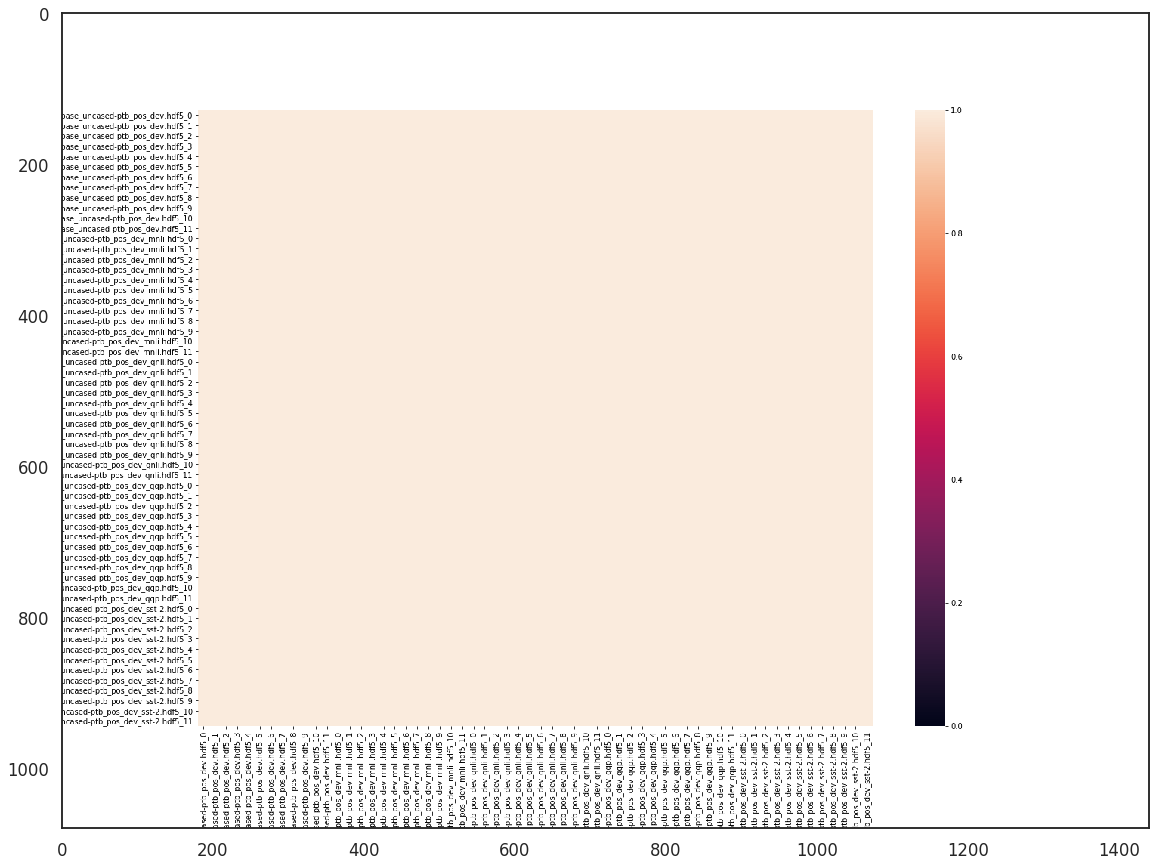

In [25]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


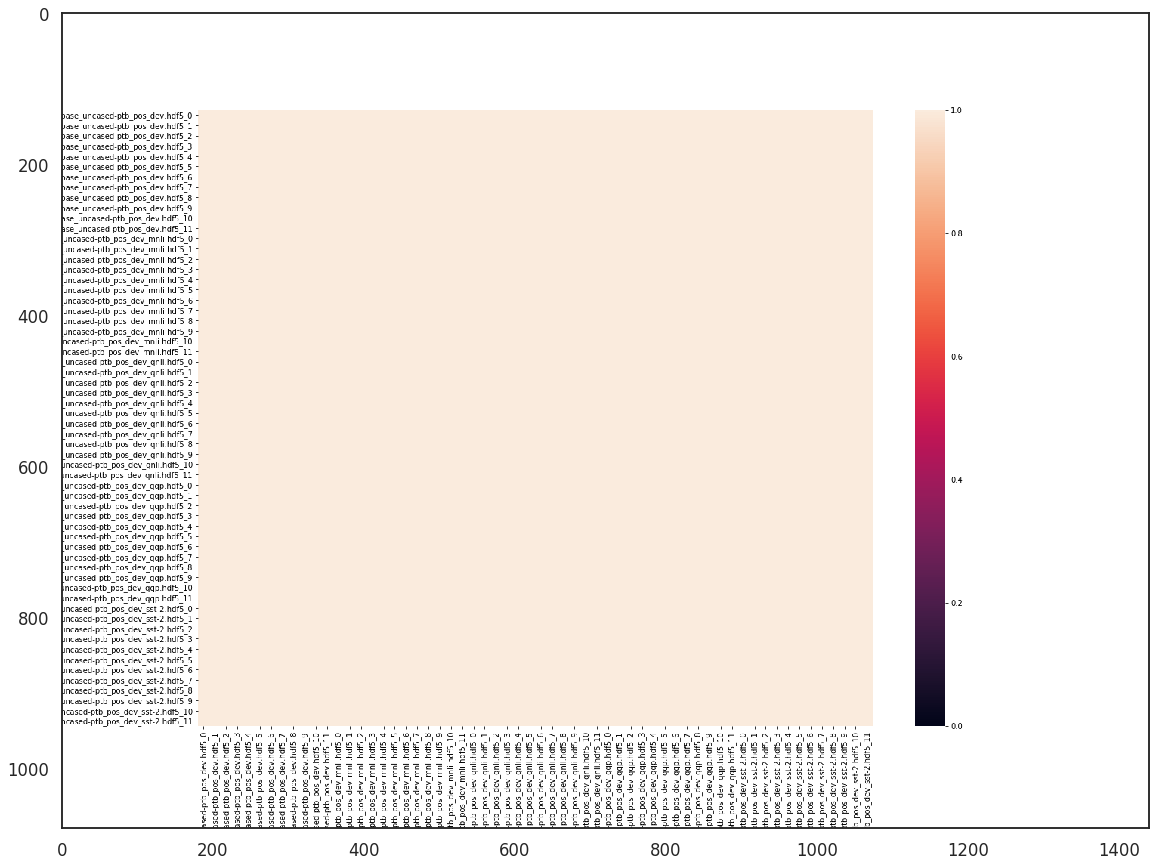

In [26]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


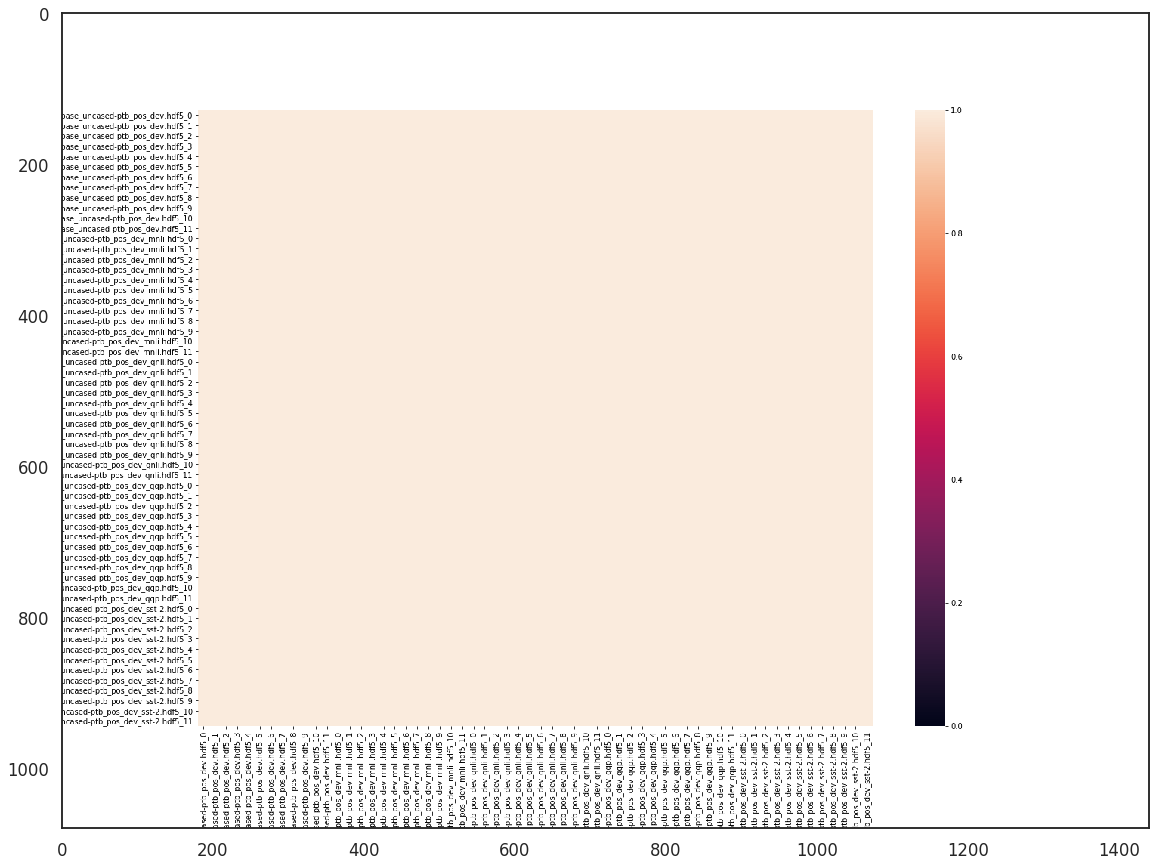

In [27]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

In [28]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [29]:
# # comparing models
# # use lincka
# model1 = "xlnet"
# model2 = "xlnet"
# cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
# rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

In [30]:
# df = lincka_df.loc[rows, cols]

# sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
# plt.xlabel(model1)
# plt.ylabel(model2)
# plt.show()

# Localized vs distributed


In [31]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

('xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5

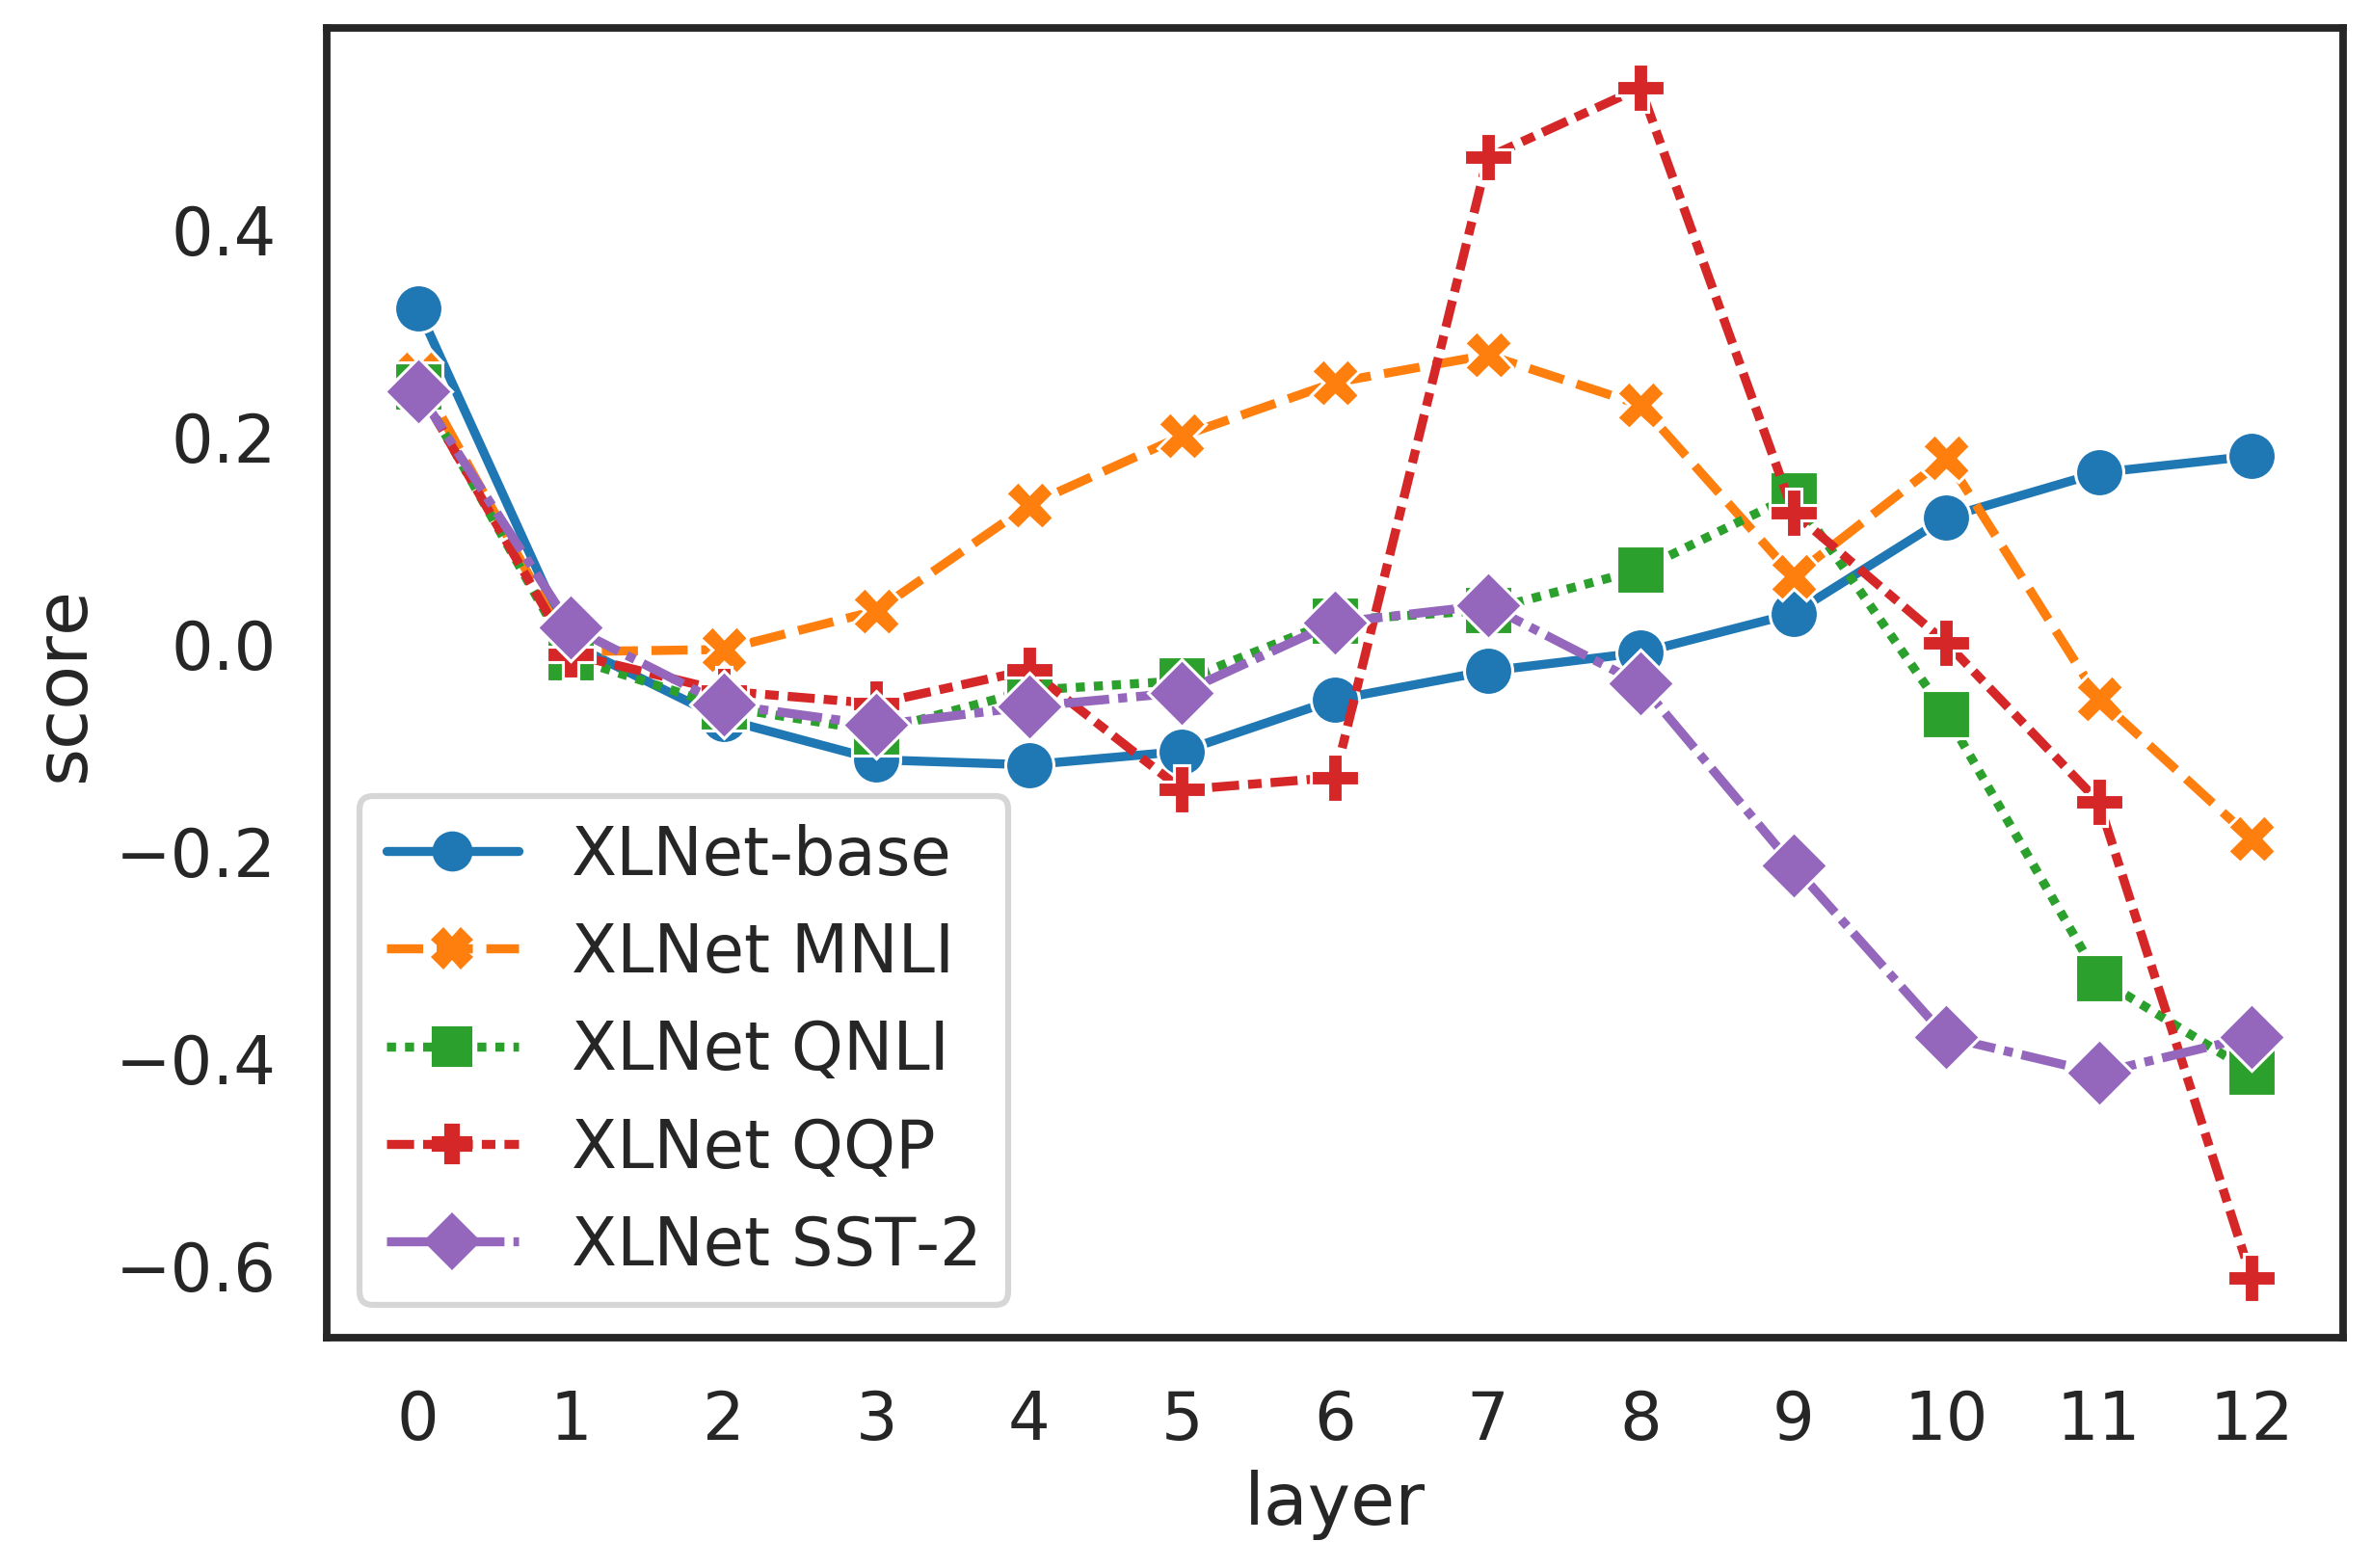

In [32]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
print(models)
models = [model.split('_')[0] + ' ' + model.split('_')[-3] for model in models]
models = ['xlnet base' if model == 'xlnet unfine' else model for model in models]
print(models)
print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
diff_df.head()
plt.figure(figsize=(9,6), dpi=300)
g = sns.lineplot(data=diff_df, x='layer', y='score', hue='model', style='model', markers=True, markersize=12)
g.set_xticks(range(13))
handles, labels = g.get_legend_handles_labels()
custom_mapping = {
    "xlnet mnli": "XLNet MNLI",
"xlnet qnli": "XLNet QNLI",
"xlnet qqp": "XLNet QQP",
"xlnet sst-2": "XLNet SST-2",
"xlnet base": "XLNet-base"

}
labels = [custom_mapping[l] for l in labels[1:]]


g.legend(handles=handles[1:], labels=labels)
# g.set_title('Localization score in layers of XLNet models')
g.get_figure().savefig('xlnet-loc-score.pdf')

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      -0.612990
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -0.414850
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -0.413896
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -0.379879
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -0.379630
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11     -0.323264
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -0.214805
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -0.188698
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -0.153317
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_5       -0.141417
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_6       -0.129582
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    -0.117324
xlnet_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    -0.112464
xlnet_base_cased-ptb_pos_

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -1.779238
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -1.724893
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -1.684650
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11     -1.623710
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10     -1.611136
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      -1.566105
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       -1.470084
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      -1.469564
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      -1.467700
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -1.467154
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8       -1.460862
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7       -1.415557
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -1.404322
xlnet_base_cased-ptb_pos_

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())

xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8       -1.996977
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7       -1.884493
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10     -1.790481
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      -1.630753
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9       -1.596352
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11     -1.569792
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8      -1.498302
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -1.495952
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      -1.468251
xlnet_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -1.365342
xlnet_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -1.345263
xlnet_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -1.313837
xlnet_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_7      -1.200102
xlnet_base_cased-ptb_pos_